In [1]:
local = True

In [2]:
if not local:
    ! pip install sdv
    ! pip install gretel-synthetics

In [3]:
import sys

import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np
import collections as coll
import tqdm

#from synthetic_data_generation.generator import *
# Import libraries
from sdv.sequential.par import PARSynthesizer
from sdv.datasets.local import load_csvs
from sdv.metadata import SingleTableMetadata

import matplotlib.dates as md
import torch
from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType
import dtw

if local:
    sys.path.append('../../src/')
    from similarity_check.SimilarityCheck import *
    from privacy_check.privacy_check import PrivacyCheck


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [33]:
def get_energy_data_metadata(rows_limit = 1000, interpolate = True, drop_na_cols = True):
    datasets = load_csvs(folder_name='./data/') if local else load_csvs(folder_name='.')
    df = datasets["energy_dataset"].iloc[:rows_limit]
    if drop_na_cols:
        df = df.dropna(axis = 1, how = "all")
    if interpolate:
        df = df.interpolate()
    
    # Switch the shape of the dataframe to long format
    gen_columns = list(filter(lambda x: "generation" in x, df.columns))
    df_long = df.melt(["time"], gen_columns)
    df_long.columns = ["time","energy_source", "value"]

    # Clean time and energy_source column
    df_long["time"] = pd.to_datetime(df_long["time"], utc = True).dt.tz_localize(None) # tz.localize transforms column to timezone-naive
    df_long["energy_source"] = df_long["energy_source"].apply(lambda x: x.replace("generation ", ""))

    # Metadata
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df_long)

    metadata.update_column(
        "energy_source",
        sdtype='id',
    )
    metadata.set_sequence_key("energy_source")
    metadata.update_column(
        column_name='time',
        sdtype='datetime',
        datetime_format='%Y-%m-%d %H:%M:%S')
    metadata.set_sequence_index(column_name='time')


    return df_long, metadata

def plot_original_synthetic_ts(df_original, df_synth, count_real = 5, count_synth = 1):
    # Plot original data vs. synthetic data
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    by_source = df_original.groupby('energy_source')
    MAX_COUNT = [count_real, count_synth]
    c = 0

    for i, df in enumerate([df_original, df_synth]):
        by_source = df.groupby('energy_source')
        c = 0
        for name, group in by_source:
            if i == 1:
                name = None
            if c == MAX_COUNT[i]:
                break
            c += 1
            axs[i].plot(group['time'], group['value'], label=name)
        if i == 0:
            axs[i].legend()
        axs[i].set_xlabel("Date")
        axs[i].set_ylabel("Energy generation")

    axs[0].set_title("Original data")
    axs[1].set_title("Synthetic data")
    plt.show()

def compute_dtw_matrix(df_original, df_synth, metadata):
    """
    Function that computes the DTW for every combination of original & synthetic sequences.

    :param df_original: original dataframe in long format
    :param df_synth: synthetic dataframe generated with PAR
    :param metadata: metadata of original dataframe

    -----------

    Returns: DataFrame with distance matrix
    """
    meta_dict = metadata.to_dict()
    sequence_key, sequence_index = meta_dict["sequence_key"], meta_dict["sequence_index"]
    ts_col = list(filter(lambda x: x not in [sequence_key, sequence_index], df_synth.columns))[0]
    sequence_key_values_synth = df_synth[sequence_key].unique()
    sequence_key_values_original = df_original[sequence_key].unique()

    dist_matrix = pd.DataFrame(np.zeros((len(sequence_key_values_synth), len(sequence_key_values_original))), columns=sequence_key_values_original,
                               index=sequence_key_values_synth)


    for i, row in enumerate(dist_matrix.iterrows()):
        synth_key, row = row
        ts_synth = df_synth[df_synth[sequence_key] == synth_key][ts_col].dropna().values
        if len(ts_synth) == 0:
            dist_matrix.iloc[i, :] = np.full(len(sequence_key_values_original),np.nan)
            continue
        for j, original_key in enumerate(sequence_key_values_original):
            ts_original = df_original[df_original[sequence_key] == original_key][ts_col].dropna().values
            if len(ts_original) == 0:
                dist_matrix.iloc[i, j] = np.nan
                continue
            alignment = dtw.dtw(ts_synth, ts_original)
            dist = alignment.normalizedDistance
            dist_matrix.iloc[i, j] = dist


    return dist_matrix

# Possible methods
For the generation of synthetic datasets with time series data, we have several methods at our disposal:
- PARSynthesizer (```sdv```): Probabilistic AutoRegressive model that allows learning multi-type, multivariate timeseries data and later on generate new synthetic data that has the same format and properties as the learned one.
- DoppelGANger (```gretel-synthetics```): DoppelGANger is based on a generative adversarial network (GAN) with some modifications to better fit the time series generation task.
- TimeGAN (```ydata-synthetic```): GAN based adapted to time series using a new concept: supervised loss.

## PARSynthesizer

### Full dataset

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
# Step 1: Create the synthesizer
synthesizer = PARSynthesizer(metadata, verbose = True, epochs = 5, cuda = True)

# Step 2: Train the synthesizer
synthesizer.fit(df)

# Step 3: Generate synthetic data.
synthetic_data = synthesizer.sample(num_sequences=5)

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
Epoch 5 | Loss 9.208951814798638e-05: 100%|██████████| 5/5 [13:13<00:00, 158.65s/it]
100%|██████████| 5/5 [00:00<00:00, 42.91it/s]


In [ ]:
synthetic_data = synthesizer.sample(num_sequences=1000)

100%|██████████| 1000/1000 [00:07<00:00, 132.71it/s]


In [ ]:
synthetic_data

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,id
0,NaN,NaN,NaN,5
1,NaN,NaN,5886.168980,6
2,329.164791,149.625888,5532.381462,7
3,NaN,385.316568,4701.346904,8
4,NaN,273.639084,NaN,9
...,...,...,...,...
995,NaN,0.000000,5308.164467,1000
996,NaN,NaN,6454.271889,1001
997,403.984260,999.000000,NaN,1002
998,425.551263,NaN,3069.256701,1003


In [ ]:
synthetic_data = synthetic_data.drop("id", axis = 1)

In [ ]:
na_rows = synthetic_data.isna().apply(lambda x: np.prod(x), axis = 1).sum()
synthetic_data.isna()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas
0,True,True,True
1,True,True,False
2,False,False,False
3,True,False,False
4,True,False,True
...,...,...,...
995,True,False,False
996,True,True,False
997,False,False,True
998,False,True,False


In [ ]:
print(f"We have {na_rows} rows that contain only NA values")

We have 146 rows that contain only NA values


In [ ]:
# Setup for our dataset
df = datasets["energy_dataset"]
df = df[["time", "generation biomass", "generation fossil brown coal/lignite", "generation fossil gas"]]
df["time"] = df["time"].apply(lambda x: x[:-6])
df["time"] = pd.to_datetime(df["time"])

In [ ]:
df

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas
0,2015-01-01 00:00:00,447.0,329.0,4844.0
1,2015-01-01 01:00:00,449.0,328.0,5196.0
2,2015-01-01 02:00:00,448.0,323.0,4857.0
3,2015-01-01 03:00:00,438.0,254.0,4314.0
4,2015-01-01 04:00:00,428.0,187.0,4130.0
...,...,...,...,...
35059,2018-12-31 19:00:00,297.0,0.0,7634.0
35060,2018-12-31 20:00:00,296.0,0.0,7241.0
35061,2018-12-31 21:00:00,292.0,0.0,7025.0
35062,2018-12-31 22:00:00,293.0,0.0,6562.0


### Smaller dataset

#### With NA values

In [13]:
df_long, metadata = get_energy_data_metadata(interpolate=False, drop_na_cols=False)

/opt/anaconda3/envs/CRP3/lib/python3.10/site-packages/sdv/datasets/local.py:31: UserWarning: Ignoring incompatible files ['.DS_Store'] in folder './data/'.
  warnings.warn(
2023-05-17 15:56:46,083 : MainThread : INFO : Detected metadata:
2023-05-17 15:56:46,083 : MainThread : INFO : {
    "columns": {
        "time": {
            "sdtype": "datetime"
        },
        "energy_source": {
            "sdtype": "categorical"
        },
        "value": {
            "sdtype": "numerical"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}


In [6]:
df_long

,time,energy_source,value
0,2014-12-31 23:00:00+00:00,biomass,447.0
1,2015-01-01 00:00:00+00:00,biomass,449.0
2,2015-01-01 01:00:00+00:00,biomass,448.0
3,2015-01-01 02:00:00+00:00,biomass,438.0
4,2015-01-01 03:00:00+00:00,biomass,428.0
...,...,...,...
20995,2015-02-11 10:00:00+00:00,wind onshore,9396.0
20996,2015-02-11 11:00:00+00:00,wind onshore,8364.0
20997,2015-02-11 12:00:00+00:00,wind onshore,7684.0
20998,2015-02-11 13:00:00+00:00,wind onshore,6762.0


In [7]:
# Step 1: Create the synthesizer
synthesizer = PARSynthesizer(metadata, verbose = True, epochs = 50, cuda = True)

# Step 2: Train the synthesizer
synthesizer.fit(df_long)

2023-05-17 15:41:44,925 : MainThread : INFO : Fitting table None metadata
2023-05-17 15:41:44,927 : MainThread : INFO : Fitting formatters for table None
2023-05-17 15:41:44,928 : MainThread : INFO : Fitting constraints for table None
2023-05-17 15:41:44,928 : MainThread : INFO : Setting the configuration for the ``HyperTransformer`` for table None
2023-05-17 15:41:45,012 : MainThread : INFO : Fitting table None metadata
2023-05-17 15:41:45,013 : MainThread : INFO : Fitting formatters for table None
2023-05-17 15:41:45,014 : MainThread : INFO : Fitting constraints for table None
2023-05-17 15:41:45,014 : MainThread : INFO : Fitting HyperTransformer for table None
2023-05-17 15:41:45,022 : MainThread : INFO : Fitting table None metadata
2023-05-17 15:41:45,022 : MainThread : INFO : Fitting formatters for table None
2023-05-17 15:41:45,023 : MainThread : INFO : Fitting constraints for table None
2023-05-17 15:41:45,023 : MainThread : INFO : Setting the configuration for the ``HyperTransf

In [14]:
# Analyzing NA values
epochs_list = [5, 10, 50, 100, 200]
na_values = []
for epochs in epochs_list:
    # Step 1: Create the synthesizer
    synthesizer = PARSynthesizer(metadata, verbose = True, epochs = epochs, cuda = True)
    # Step 2: Train the synthesizer
    synthesizer.fit(df_long)
    # Step 3: Generate synthetic data.
    synthetic_data = synthesizer.sample(num_sequences=1)
    na_count = synthetic_data.isna().sum()["value"]
    na_values.append(na_count)

2023-05-17 15:56:51,213 : MainThread : INFO : Fitting table None metadata
2023-05-17 15:56:51,215 : MainThread : INFO : Fitting formatters for table None
2023-05-17 15:56:51,216 : MainThread : INFO : Fitting constraints for table None
2023-05-17 15:56:51,217 : MainThread : INFO : Setting the configuration for the ``HyperTransformer`` for table None
2023-05-17 15:56:51,304 : MainThread : INFO : Fitting table None metadata
2023-05-17 15:56:51,305 : MainThread : INFO : Fitting formatters for table None
2023-05-17 15:56:51,306 : MainThread : INFO : Fitting constraints for table None
2023-05-17 15:56:51,306 : MainThread : INFO : Fitting HyperTransformer for table None
2023-05-17 15:56:51,314 : MainThread : INFO : Fitting table None metadata
2023-05-17 15:56:51,315 : MainThread : INFO : Fitting formatters for table None
2023-05-17 15:56:51,315 : MainThread : INFO : Fitting constraints for table None
2023-05-17 15:56:51,315 : MainThread : INFO : Setting the configuration for the ``HyperTransf

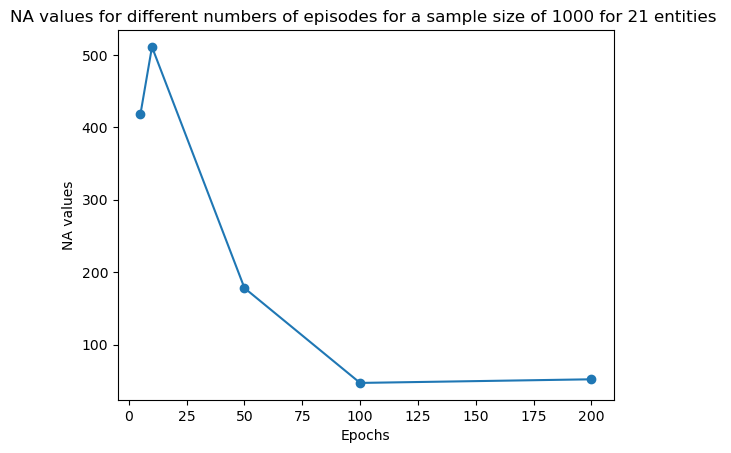

In [15]:
# Plot NA values
plt.plot(epochs_list, na_values, marker = "o")
plt.title("NA values for different numbers of episodes for a sample size of 1000 for 21 entities ")
plt.xlabel("Epochs")
plt.ylabel("NA values")
plt.show()

In [16]:
synthetic_data_plot = synthesizer.sample(5)

100%|██████████| 5/5 [00:22<00:00,  4.51s/it]
/opt/anaconda3/envs/CRP3/lib/python3.10/site-packages/sdv/data_processing/data_processor.py:751: FutureWarning: Using .astype to convert from timezone-naive dtype to timezone-aware dtype is deprecated and will raise in a future version.  Use ser.dt.tz_localize instead.
  reversed_data[column_name] = column_data[column_data.notna()].astype(dtype)


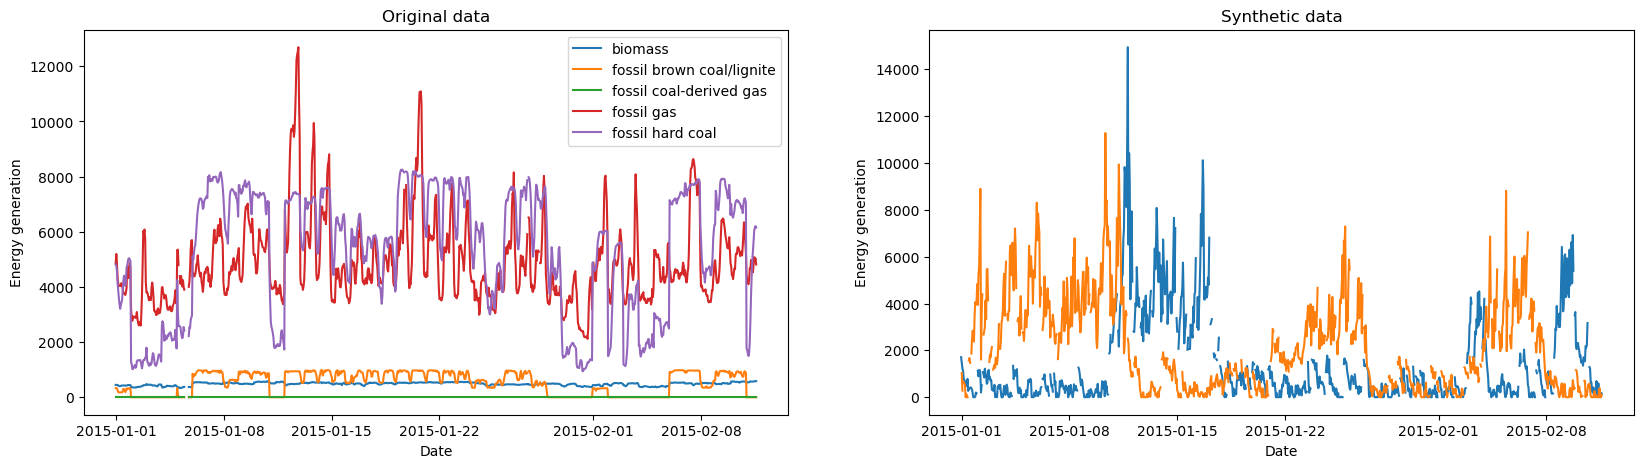

In [19]:
plot_original_synthetic_ts(df_long, synthetic_data_plot, 5, 2)

#### Interpolating NA values

In [23]:
df_long, metadata = get_energy_data_metadata(rows_limit=1000, interpolate= True, drop_na_cols=True)

/opt/anaconda3/envs/CRP3/lib/python3.10/site-packages/sdv/datasets/local.py:31: UserWarning: Ignoring incompatible files ['.DS_Store'] in folder './data/'.
  warnings.warn(
2023-05-23 15:56:04,387 : MainThread : INFO : Detected metadata:
2023-05-23 15:56:04,387 : MainThread : INFO : {
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "time": {
            "sdtype": "datetime"
        },
        "energy_source": {
            "sdtype": "categorical"
        },
        "value": {
            "sdtype": "numerical"
        }
    }
}


In [24]:
# Load model
synthesizer = PARSynthesizer.load("./models/energy1000_300ep_linint.pkl")

synth_data = synthesizer.sample(5)

100%|██████████| 5/5 [00:31<00:00,  6.32s/it]
/opt/anaconda3/envs/CRP3/lib/python3.10/site-packages/sdv/data_processing/data_processor.py:751: FutureWarning: Using .astype to convert from timezone-naive dtype to timezone-aware dtype is deprecated and will raise in a future version.  Use ser.dt.tz_localize instead.
  reversed_data[column_name] = column_data[column_data.notna()].astype(dtype)


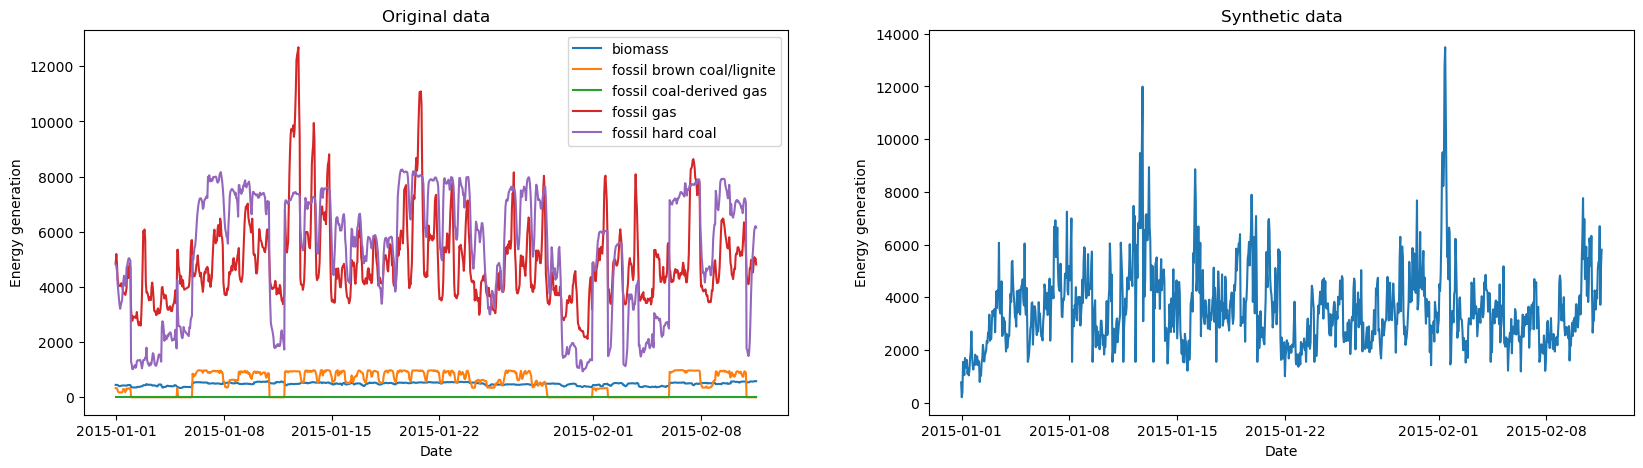

In [7]:
plot_original_synthetic_ts(df_long, synth_data, 5, 1)

# Compute DTW between synthetic and original

In [27]:
df_long, metadata = get_energy_data_metadata()

/opt/anaconda3/envs/CRP3/lib/python3.10/site-packages/sdv/datasets/local.py:31: UserWarning: Ignoring incompatible files ['.DS_Store'] in folder './data/'.
  warnings.warn(
2023-05-17 16:09:45,072 : MainThread : INFO : Detected metadata:
2023-05-17 16:09:45,072 : MainThread : INFO : {
    "columns": {
        "time": {
            "sdtype": "datetime"
        },
        "energy_source": {
            "sdtype": "categorical"
        },
        "value": {
            "sdtype": "numerical"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}


In [28]:
# Step 1: Create the synthesizer
#synthesizer = PARSynthesizer(metadata, verbose = True, epochs = 300, cuda = True)

# Step 2: Train the synthesizer
#synthesizer.fit(df_long)

In [29]:
#synthesizer_no_na.save("models/energy1000_300ep_lin_int.pkl")

In [29]:
# Load synthesizer that you want
synthesizer = PARSynthesizer.load("models/energy1000_300ep_linint.pkl")

In [30]:
# Sample from it
synth_data = synthesizer.sample(50)

100%|██████████| 50/50 [03:36<00:00,  4.32s/it]
/opt/anaconda3/envs/CRP3/lib/python3.10/site-packages/sdv/data_processing/data_processor.py:751: FutureWarning: Using .astype to convert from timezone-naive dtype to timezone-aware dtype is deprecated and will raise in a future version.  Use ser.dt.tz_localize instead.
  reversed_data[column_name] = column_data[column_data.notna()].astype(dtype)


In [34]:
synth_data.to_csv("synthetic_data/energy1000_50samples.csv")

In [32]:
dist_matrix = compute_dtw_matrix(df_long, synth_data, metadata)

In [39]:
dist_matrix

,biomass,fossil brown coal/lignite,fossil coal-derived gas,fossil gas,fossil hard coal,fossil oil,fossil oil shale,fossil peat,geothermal,hydro pumped storage consumption,hydro run-of-river and poundage,hydro water reservoir,marine,nuclear,other,other renewable,solar,waste,wind offshore,wind onshore
00000,1740.077627,1574.136485,2272.679979,539.711625,578.650617,1915.291641,2272.679979,2272.679979,2272.679979,966.579904,1140.863771,507.132080,2272.679979,737.884196,2194.618065,2206.032880,773.621067,2025.945305,2272.679979,909.870105
00001,1684.291265,1687.673654,2185.913486,461.801588,560.209845,1877.030004,2185.913486,2185.913486,2185.913486,985.778932,1284.993563,543.524721,2185.913486,687.158509,2115.938865,2117.932986,753.465567,1953.140486,2185.913486,930.718768
0000a,2056.748303,1856.338435,2565.151825,496.556128,536.835586,2220.607255,2565.151825,2565.151825,2565.151825,1023.201786,1299.243927,549.547197,2565.151825,730.586968,2493.653226,2493.295563,841.904441,2329.287680,2565.151825,910.700817
0000b,1635.529580,1554.440775,1927.869699,543.438150,566.916904,1665.481335,1927.869699,1927.869699,1927.869699,919.812927,1120.399794,540.590472,1927.869699,718.484520,1863.345993,1858.497699,741.879895,1704.078199,1927.869699,983.394927
0000c,1753.547950,1572.803872,2276.205867,557.324432,559.122148,1929.081267,2276.205867,2276.205867,2276.205867,974.416407,1176.142323,517.703449,2276.205867,736.397914,2199.709023,2207.682281,778.685201,2033.659335,2276.205867,1022.978654
0000d,922.306632,826.473471,1175.507299,809.478942,675.781242,1008.535337,1175.507299,1175.507299,1175.507299,573.291420,562.094683,440.343616,1175.507299,1330.423285,1139.779939,1147.702720,609.822725,1057.204754,1175.507299,1481.639603
0000e,1863.302798,1647.062788,2349.327782,531.718644,560.613902,2026.410323,2349.327782,2349.327782,2349.327782,946.893604,1175.007911,490.688254,2349.327782,742.936709,2285.727668,2278.526641,787.888382,2131.151007,2349.327782,985.602991
0000f,1661.339609,1472.071511,2150.899862,629.694977,612.344537,1821.018037,2150.899862,2150.899862,2150.899862,861.129871,1019.184514,469.966510,2150.899862,860.051825,2085.422024,2079.204186,760.952083,1929.519933,2150.899862,956.330894
0000g,1299.449474,1200.562222,1562.949943,647.037138,580.357797,1388.375668,1562.949943,1562.949943,1562.949943,783.771513,932.644211,497.255179,1562.949943,1031.275485,1529.648597,1538.003403,692.862545,1443.423113,1562.949943,1080.080456
0000h,817.604635,729.255273,1050.317870,910.210246,614.969025,890.703737,1050.317870,1050.317870,1050.317870,568.558294,641.675853,493.614696,1050.317870,1422.496649,1012.870051,1020.009624,587.389553,933.419514,1050.317870,1161.988113


In [40]:
dist_matrix.describe()

,biomass,fossil brown coal/lignite,fossil coal-derived gas,fossil gas,fossil hard coal,fossil oil,fossil oil shale,fossil peat,geothermal,hydro pumped storage consumption,hydro run-of-river and poundage,hydro water reservoir,marine,nuclear,other,other renewable,solar,waste,wind offshore,wind onshore
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,1511.922159,1390.960866,1913.409407,595.606603,566.732350,1641.318692,1913.409407,1913.409407,1913.409407,839.662144,1015.177193,501.090132,1913.409407,892.709867,1854.895862,1858.778803,727.019623,1723.140200,1913.409407,1007.719084
std,312.339281,286.402788,395.712105,133.666874,42.293012,337.806803,395.712105,395.712105,395.712105,124.934552,187.367704,26.870744,395.712105,254.273908,381.635010,380.178051,64.769388,354.576041,395.712105,144.132773
min,386.737907,340.194841,579.797993,461.801588,516.925578,438.323567,579.797993,579.797993,579.797993,366.283785,320.762058,440.343616,579.797993,664.867240,546.115047,553.295618,496.688176,475.065001,579.797993,853.872063
25%,1430.177946,1353.348914,1770.395699,532.397810,549.946963,1545.086368,1770.395699,1770.395699,1770.395699,795.027450,974.862427,485.175891,1770.395699,744.446377,1767.242578,1767.099658,697.668242,1621.081070,1770.395699,916.962992
50%,1558.441785,1445.235574,2018.849644,553.128824,560.411874,1701.088877,2018.849644,2018.849644,2018.849644,858.651496,1035.199856,497.210591,2018.849644,829.473635,1947.161960,1950.889858,740.462424,1800.390850,2018.849644,979.806142
75%,1714.616183,1558.101976,2177.160080,591.519647,575.069525,1871.905720,2177.160080,2177.160080,2177.160080,918.625661,1129.905206,517.504336,2177.160080,889.552716,2108.309654,2108.250786,769.972763,1947.235348,2177.160080,1035.424864
max,2056.748303,1856.338435,2565.151825,1222.943826,793.857956,2220.607255,2565.151825,2565.151825,2565.151825,1023.201786,1299.243927,585.348615,2565.151825,2042.246524,2493.653226,2493.295563,841.904441,2329.287680,2565.151825,1601.702915


# Error debugging

In [8]:
datasets = load_csvs(folder_name='./data/') if local else load_csvs(folder_name='.')
df = datasets["energy_dataset"].iloc[:1000]


# Switch the shape of the dataframe to long format
gen_columns = list(filter(lambda x: "generation" in x, df.columns))
df_long = df.melt(["time"], gen_columns)
df_long.columns = ["time","energy_source", "value"]

# Clean time and energy_source column
df_long["time"] = pd.to_datetime(df_long["time"], utc = True)

/opt/anaconda3/envs/CRP3/lib/python3.10/site-packages/sdv/datasets/local.py:31: UserWarning: Ignoring incompatible files ['.DS_Store'] in folder './data/'.
  warnings.warn(


In [18]:
df_long["time"]

0       2014-12-31 23:00:00+00:00
1       2015-01-01 00:00:00+00:00
2       2015-01-01 01:00:00+00:00
3       2015-01-01 02:00:00+00:00
4       2015-01-01 03:00:00+00:00
                   ...           
20995   2015-02-11 10:00:00+00:00
20996   2015-02-11 11:00:00+00:00
20997   2015-02-11 12:00:00+00:00
20998   2015-02-11 13:00:00+00:00
20999   2015-02-11 14:00:00+00:00
Name: time, Length: 21000, dtype: datetime64[ns, UTC]

In [34]:
df_long, metadata = get_energy_data_metadata(rows_limit=1000, interpolate= True, drop_na_cols=True)

/opt/anaconda3/envs/CRP3/lib/python3.10/site-packages/sdv/datasets/local.py:31: UserWarning: Ignoring incompatible files ['.DS_Store'] in folder './data/'.
  warnings.warn(
2023-05-23 15:59:47,901 : MainThread : INFO : Detected metadata:
2023-05-23 15:59:47,901 : MainThread : INFO : {
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "time": {
            "sdtype": "datetime"
        },
        "energy_source": {
            "sdtype": "categorical"
        },
        "value": {
            "sdtype": "numerical"
        }
    }
}


In [35]:
# Step 1: Create the synthesizer
synthesizer = PARSynthesizer(metadata, verbose = True, epochs = 10, cuda = True)

# Step 2: Train the synthesizer
synthesizer.fit(df_long)

2023-05-23 15:59:49,008 : MainThread : INFO : Fitting table None metadata
2023-05-23 15:59:49,010 : MainThread : INFO : Fitting formatters for table None
2023-05-23 15:59:49,011 : MainThread : INFO : Fitting constraints for table None
2023-05-23 15:59:49,011 : MainThread : INFO : Setting the configuration for the ``HyperTransformer`` for table None
2023-05-23 15:59:49,036 : MainThread : INFO : Fitting table None metadata
2023-05-23 15:59:49,037 : MainThread : INFO : Fitting formatters for table None
2023-05-23 15:59:49,038 : MainThread : INFO : Fitting constraints for table None
2023-05-23 15:59:49,038 : MainThread : INFO : Fitting HyperTransformer for table None
2023-05-23 15:59:49,048 : MainThread : INFO : Fitting table None metadata
2023-05-23 15:59:49,049 : MainThread : INFO : Fitting formatters for table None
2023-05-23 15:59:49,049 : MainThread : INFO : Fitting constraints for table None
2023-05-23 15:59:49,049 : MainThread : INFO : Setting the configuration for the ``HyperTransf

In [36]:
synthesizer.sample(2)

100%|██████████| 2/2 [00:13<00:00,  6.62s/it]


,time,energy_source,value
0,2014-12-31 23:00:00,00000,0.000000
1,2015-01-01 00:00:00,00000,1550.342925
2,2015-01-01 01:00:00,00000,1550.342925
3,2015-01-01 02:00:00,00000,1550.342925
4,2015-01-01 03:00:00,00000,3750.611197
...,...,...,...
1995,2015-02-11 10:00:00,00001,1550.342925
1996,2015-02-11 11:00:00,00001,2866.194681
1997,2015-02-11 12:00:00,00001,2129.975063
1998,2015-02-11 13:00:00,00001,4665.900305
